# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

In [6]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *


$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] = L^3 \langle (\mathcal{O} - \bar{\mathcal{O}})^2\rangle $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2} = \frac{ \langle \left( \mathcal{O-\bar{\mathcal{O}}} \right) ^4 \rangle }{\chi_\mathcal{O}^2}$$ 

In [7]:
def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
    
    mode=2
    
    if mode==1: ## Using gvar for error propagation
        m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
        m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
        for i in range(1,5):
            m[i]=gv.dataset.avg_data(y**i)

        # Check moments obtained by gvar, with direct calculation
        n=[gv.gvar(0,0) for i in range(5)]  # List to store moments
        n[0]=gv.gvar(1,1e-16) # zeroth moment is 1
        for i in range(1,5):
            arr=y**i
            n[i]=gv.gvar(np.mean(arr),np.std(arr)/np.sqrt(arr.shape[0]))

        sus=(L**3)*(m[2]-(m[1]**2))
        if sus>1e-7: 
            kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
        else: kurt=gv.gvar(np.nan,np.nan)
        print("mode 1")
    
    elif mode==2: ## Propagating errors for high correlated variables doesn't work, so we use jackknife
        ### Compute arrays of moments
        m=[y**i for i in range(0,5)] # List to store powers of input

        ## Compute sus and kurt by jackknifing elements of this list
        arr=(y-np.mean(y))**2
        sus=(L**3) * f_jackknife(arr)
    #     print(sus)

        if sus>1e-7:
    #         arr=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
            arr=((y-np.mean(y))**4)
            kurt= f_jackknife(arr) / (gv.mean(sus)**2)
        else: kurt=gv.gvar(np.nan,np.nan)
    
    return sus,kurt

In [8]:
def f_get_run_summary(df_summary,Lx,Lt,top_dir,run_label):
    '''
    Combine results from multiple runs
    
    '''
    fldr_list=glob.glob(top_dir+'run_Lx-%s_Lt-%s*'%(Lx,Lt))
    # print(fldr_list)

    for run_fldr in fldr_list: 
        print(run_fldr)
        # Read config file from folder
        input_dict=f_read_config(run_fldr+'/config.yaml')

        # Extract info from HMC output 
        flist=glob.glob(run_fldr+'/HSDM?.out')
        if len(flist)<1:    
            print("Not file HSDM*.out in %s"%(run_fldr))
            continue

        # sort output file list sequentially
        flist=[file_name.split('HSDM')[0]+'HSDM%s.out'%(i+1) for i,file_name in enumerate(flist)]

        ## Sum results from successive runs
        for idx,fname in enumerate(flist):

            try : 
                df_a=f_parse_grid_data(fname)
    #             display(a)
            except Exception as e:
                print(e,fname)
                continue

            if idx==0:
                df=df_a.copy()
            else : 
                df=f_merge_df_successive_runs(df,df_a)

        # Choose equilibriation
        equil = max(80,int(df.shape[0]*0.25))
        print("Equil",equil)
        if equil>=df.shape[0]:
            print("Skipping %s, not enough configs"%(fname))
            continue

        # Add to dictionary
        key='beta-%s_mf-%s_Lx-%s_Lt-%s'%(input_dict['beta'],input_dict['mf'],input_dict['Lx'],input_dict['Lt'])
        
        if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
            key+='_Ls-%s'%(input_dict['dwf_Ls'])

        key+='_'+run_label
        
        count=1
        while(key in data_dict.keys()): # If duplicate key, add suffix
            print("Key exists",key,fname)
            count+=1
            key=key+'_%s'%(count)
            if count>10: break

        data_dict[key]=df

        # Get summary data
        dict2={}
        for key in ['beta','mf','Lx','Lt']:   dict2[key]=input_dict[key]
        if input_dict['F_action'] =='Mobius_dwf': ## Add Ls in label for DWF
            dict2['Ls']=input_dict['dwf_Ls']
        dict2=f_get_summary_data(df,input_dict['Lx'],dict2,equil)

        dict2['run_type']=run_label
        df_summary=pd.concat([df_summary,pd.DataFrame(dict2,index=[df_summary.shape[0]+1])])    
    
    return df_summary,data_dict


In [9]:
# df_summary

In [10]:
Lx='*'
Lt='*'
data_dict={}
df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/'
df_summary,data_dict = f_get_run_summary(df_summary,'*','*',top_dir,'hot-start')

# Drop rows with no values
df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)

# Traj l = 2, so num_conf is twice the value
df_summary['num_conf']=df_summary['num_conf']*2

display(df_summary)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.0_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.2_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.4_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.6_mf-0.1
Equil 242
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.8_mf-0.1
Equil 646
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1
Equil 381
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-11.2_mf-0.1
Equil

Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-12_Ls-16_beta-12.5_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-12_Ls-16_beta-14.0_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-24_Lt-12_Ls-16_beta-13.5_mf-0.1
Equil 80
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.9_mf-0.1
Equil 417
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-12.5_mf-0.1
Equil 352
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/phase_diagram_5_hot_start/run_Lx-16_Lt-8_Ls-16_beta-10.7_mf-0.1
Equil 289


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_type
0,10.0,0.067,24,12,16,0.413102(24),0.00086(12),1.61(48)e-08,7,0.001708(92),0.0125(20),2.0(1.0)e-08,1,559.55(23),65.168539,216,hot-start
1,10.0,0.100,16,8,16,0.413450(61),0.00138(16),1.30(28)e-07,3,0.00364(18),0.0125(27),3.0(1.8)e-07,1,141.408(25),78.125000,180,hot-start
2,10.0,0.100,24,8,16,0.413440(42),0.00281(34),1.38(38)e-08,5,0.001677(81),0.0103(13),1.53(48)e-08,1,335.897(63),71.195652,228,hot-start
3,10.0,0.100,24,12,16,0.413457(27),0.00129(17),1.68(45)e-08,5,0.001739(77),0.0109(12),1.31(32)e-08,1,477.32(12),71.782178,264,hot-start
4,10.2,0.067,24,12,16,0.441736(40),0.00116(20),1.32(32)e-08,4,0.00150(16),0.0184(39),1.73(85)e-08,1,569.27(13),68.292683,106,hot-start
5,10.2,0.100,16,8,16,0.442081(91),0.00302(36),1.32(26)e-07,4,0.00334(17),0.0107(13),1.40(34)e-07,1,142.879(30),88.607595,176,hot-start
6,10.2,0.100,24,8,16,0.441776(46),0.00335(41),1.41(39)e-08,10,0.00206(11),0.0196(31),1.99(82)e-08,1,338.533(55),77.049180,226,hot-start
7,10.4,0.067,24,12,16,0.515504(82),0.00490(97),1.59(55)e-08,8,0.00196(16),0.0189(30),1.21(48)e-08,1,566.21(28),84.552846,106,hot-start
8,10.4,0.100,16,8,16,0.51431(23),0.0215(16),9.2(1.5)e-08,23,0.00339(17),0.0111(20),2.4(1.3)e-07,1,134.023(95),92.215569,194,hot-start
9,10.4,0.100,24,8,16,0.514579(46),0.00405(49),1.61(37)e-08,7,0.001921(84),0.0136(15),1.46(42)e-08,1,321.04(14),90.995261,282,hot-start


In [11]:
df_sliced=df_summary[(df_summary.Lt.isin([8,12]))&(df_summary.mf==0.1)]
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
df_sliced=df_sliced[((df_sliced.Lt==8)&(df_sliced.Lx==16))|((df_sliced.Lt==12)&(df_sliced.Lx==24))]
# df_sliced=df_summary.copy()
print(df_sliced.shape)

display(df_sliced)


(29, 17)


,beta,mf,Lx,Lt,Ls,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_type
1,10.0,0.1,16,8,16,0.413450(61),0.00138(16),1.30(28)e-07,3,0.00364(18),0.0125(27),3.0(1.8)e-07,1,141.408(25),78.125000,180,hot-start
3,10.0,0.1,24,12,16,0.413457(27),0.00129(17),1.68(45)e-08,5,0.001739(77),0.0109(12),1.31(32)e-08,1,477.32(12),71.782178,264,hot-start
5,10.2,0.1,16,8,16,0.442081(91),0.00302(36),1.32(26)e-07,4,0.00334(17),0.0107(13),1.40(34)e-07,1,142.879(30),88.607595,176,hot-start
8,10.4,0.1,16,8,16,0.51431(23),0.0215(16),9.2(1.5)e-08,23,0.00339(17),0.0111(20),2.4(1.3)e-07,1,134.023(95),92.215569,194,hot-start
11,10.6,0.1,16,8,16,0.547056(27),0.00213(11),1.80(20)e-07,5,0.004578(86),0.0223(12),1.86(27)e-07,1,113.027(98),94.994786,1454,hot-start
13,10.6,0.1,24,12,16,0.547088(24),0.00077(11),1.46(33)e-08,2,0.00181(10),0.0131(19),1.54(63)e-08,1,403.17(59),84.756098,188,hot-start
14,10.7,0.1,16,8,16,0.556425(24),0.00198(11),2.05(24)e-07,4,0.00554(11),0.0449(26),2.26(33)e-07,2,105.86(10),92.931937,1734,hot-start
16,10.8,0.1,16,8,16,0.564353(14),0.001584(53),1.88(15)e-07,4,0.00905(12),0.1225(42),1.93(15)e-07,56,99.464(60),93.864078,3878,hot-start
18,10.9,0.1,16,8,16,0.571746(16),0.001279(51),1.80(16)e-07,3,0.02514(17),0.1454(55),1.66(13)e-07,12,91.569(97),94.277108,2506,hot-start
20,11.0,0.1,16,8,16,0.578484(17),0.001320(54),1.73(17)e-07,3,0.03390(14),0.0925(42),1.99(22)e-07,3,87.235(59),93.795380,2288,hot-start


In [13]:
# data_dict.keys()

,Lx,Lt,run_type,num_conf
beta,,,,
10.6,16,8,hot-start,1454
10.7,16,8,hot-start,1734
10.8,16,8,hot-start,3878
10.9,16,8,hot-start,2506
11.0,16,8,hot-start,2288
11.1,16,8,hot-start,2190
11.2,16,8,hot-start,2482
11.3,16,8,hot-start,2660
11.4,16,8,hot-start,2752


<IPython.core.display.Javascript object>


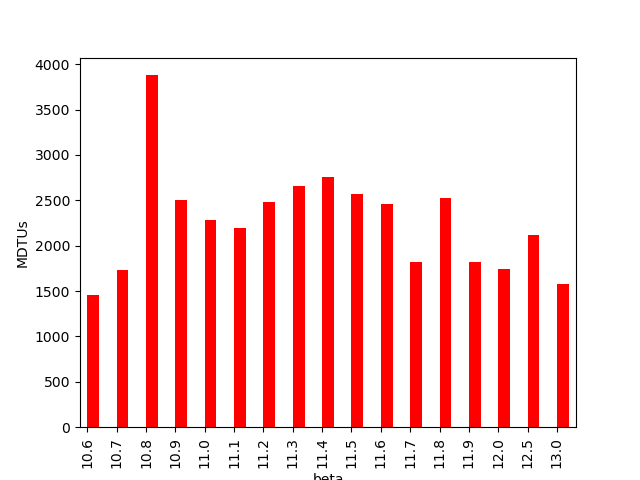

Text(0, 0.5, 'MDTUs')

In [14]:
## Plot number of configs
df=df_sliced[(df_sliced.beta>10.5)&(df_sliced.beta<13.1)&(df_sliced.Lx==16)&(df_sliced.Lt==8)]\
[['Lx','Lt','beta','run_type','num_conf']]

df.set_index('beta',inplace=True)

display(df)

width=0.4 

plt.figure()

label='hot-start'
df.num_conf.plot(kind='bar', width=width, color='red', position=0)

# plt.legend(loc='best')

plt.ylabel("MDTUs")
# plt.savefig('fig_output/num_confs_hot.pdf')

## Summary plots

In [15]:
# df_sliced=df_sliced[df_sliced.Lx==24]
mf_list   = np.sort(np.unique(df_sliced.mf.values))
beta_list = np.sort(np.unique(df_sliced.beta.values))
# Lt_list = np.sort(np.unique(df_sliced.Lt.values))

## Combining Lx and Lt into a label 
L_list=np.unique([str(i)+'_'+str(j) for i,j in zip(df_sliced.Lx.values, df_sliced.Lt.values)])
mf_list,beta_list,L_list

(array([0.1]),
 array([10. , 10.2, 10.4, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3,
        11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.5, 13. , 13.5, 14. ]),
 array(['16_8', '24_12'], dtype='<U5'))

### Plot Polyakov loop vs $\beta$ for different $m_f$

In [16]:
L_list

array(['16_8', '24_12'], dtype='<U5')

<IPython.core.display.Javascript object>


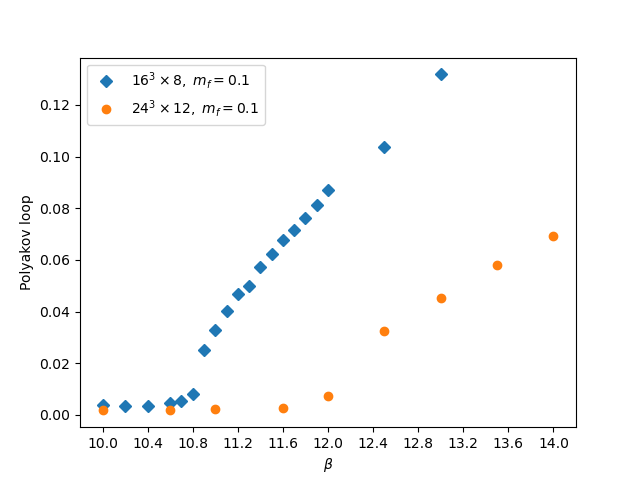

In [17]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.polyakov.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('fig_output/Ploop_vs_beta_different_Lt.pdf')

### Plaquette vs beta

<IPython.core.display.Javascript object>


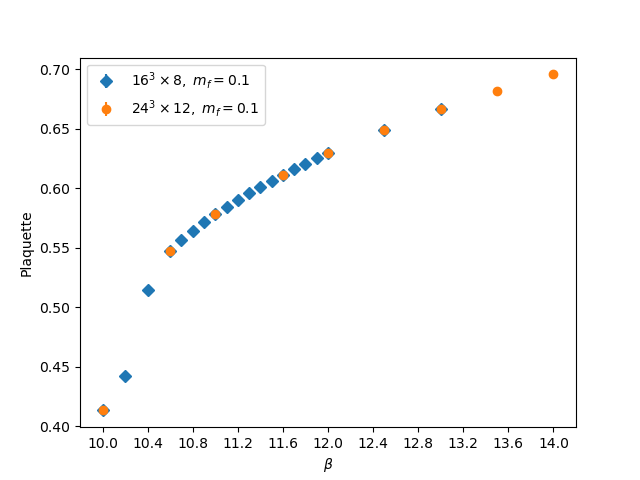

In [18]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)

        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.plaq.values
    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Plaquette',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('fig_output/Plaq_vs_beta_different_Lt.pdf')

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [19]:
# plt.figure()

# for (l,marker) in zip(L_list,itertools.cycle('o*d>^sDHPdpx_')):
#     lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
#     df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
#     for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):
#         label='beta=%s_l=%s'%(beta,l)
#         df1=df[df.beta==beta].sort_values(by=['mf'])
#     #     display(df1)

#     #     if df1.shape[0]>1:
#         x=df1.mf.values
#         y=df1.polyakov.values
#     #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Polyakov loop',rotation='vertical')
# # plt.savefig('fig_output/Ploop_vs_mf.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


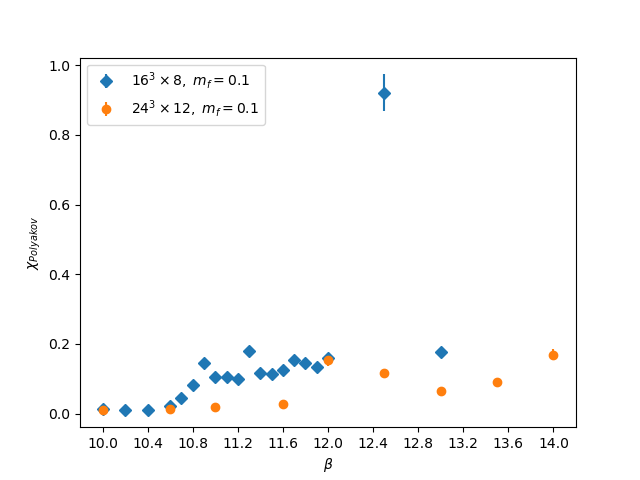

Text(0, 0.5, '$\\chi_{Polyakov}$')

In [20]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf_%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.sus_poly.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
# plt.savefig('fig_output/chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


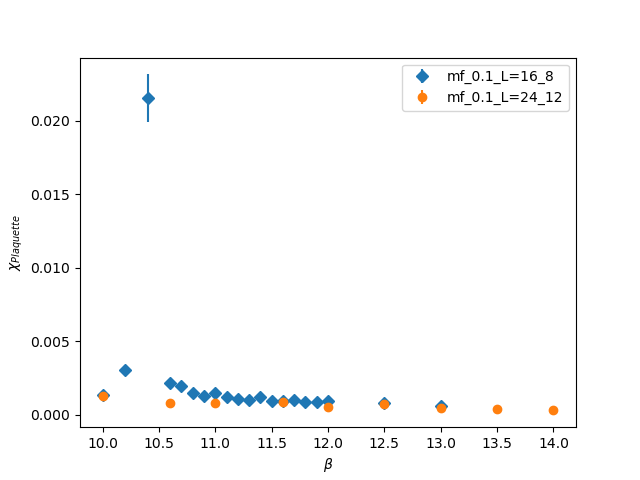

Text(0, 0.5, '$\\chi_{Plaquette}$')

In [21]:
plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.sus_plaq.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
# plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


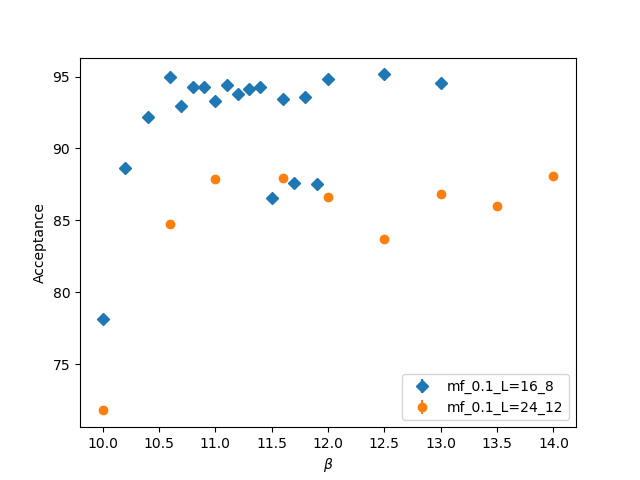

Text(0, 0.5, 'Acceptance')

In [22]:
# Plot acceptance rate 

# plt.figure()

# for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

#     label='beta_%s'%(beta)
#     df1=df_sliced[df_sliced.beta==beta].sort_values(by=['mf'])
# #     display(df1)
    
# #     if df1.shape[0]>1:
#     x=df1.mf.values
#     y=df1.accept.values
# #     print(x,y)
#     plt.plot(x,y,linestyle='',label=label,marker=marker)
# #     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

# plt.xlabel(r'$m_f$')
# # plt.xticks(mf_list)
# # plt.xlim(-0.5,2.0)
# plt.legend(loc='best')
# plt.ylabel('Acceptance',rotation='vertical')
# # plt.savefig('Acceptance_vs_mf.pdf')


plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
        label='mf_%s_L=%s'%(mf,l)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)

    #     if df1.shape[0]>1:
        x=df1.beta.values
#         y=df1.sus_plaq.values
        y=df1.accept.values

    #     print(x,y)
        plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_beta.pdf')


<IPython.core.display.Javascript object>


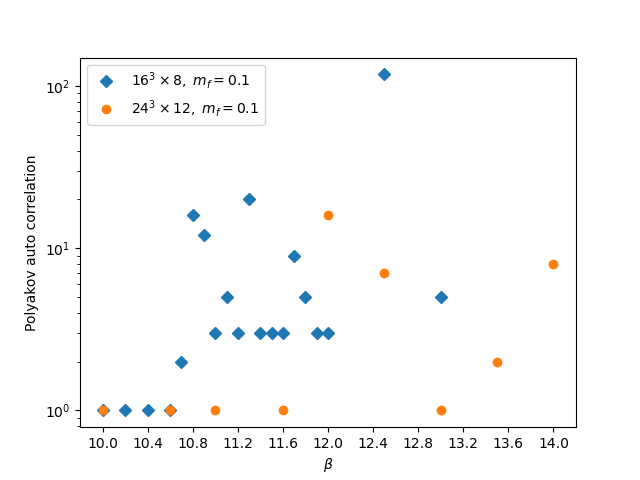

In [23]:
# Autocorrelation

plt.figure()

for (l,marker) in zip(L_list,itertools.cycle('Do*xd>^sDHPdpx_')):
    lx,lt=int(l.split('_')[0]),int(l.split('_')[1])
    df=df_sliced[(df_sliced.Lx==lx)&(df_sliced.Lt==lt)]
    for mf in mf_list:
#         label='mf=%s_L=%s'%(mf,l)
        label=r'${%s}^3 \times %s ,\ m_f=%s$'%(l.split('_')[0],l.split('_')[1],mf)
        df1=df[df.mf==mf].sort_values(by=['beta'])
#         display(df1)
        
    #     if df1.shape[0]>1:
        x=df1.beta.values
        y=df1.poly_autocorr.values
#         y=df1.plaq_autocorr.values
    #     print(x,y)
#         plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        plt.plot(x,gv.mean(y),linestyle='',label=label,marker=marker)

plt.show()
plt.xlabel(r'$\beta$')
plt.xticks(np.arange(min(beta_list),max(beta_list)+0.2,0.4))
plt.legend()
plt.ylabel('Polyakov auto correlation',rotation='vertical')
plt.yscale('log')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
# plt.savefig('fig_output/Ploop_vs_beta.pdf')

## Individual plots

In [24]:
data_dict.keys()

dict_keys(['beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-11.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-11.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-11.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-11.8_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start', 'beta-10.0_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-10.2_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-10.4_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-10.6_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-10.8_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-11.0_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-11.2_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-11.4_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-11.8_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'beta-12.0_mf-0.1_Lx-24_Lt-8_Ls-16_hot-start', 'b

<IPython.core.display.Javascript object>


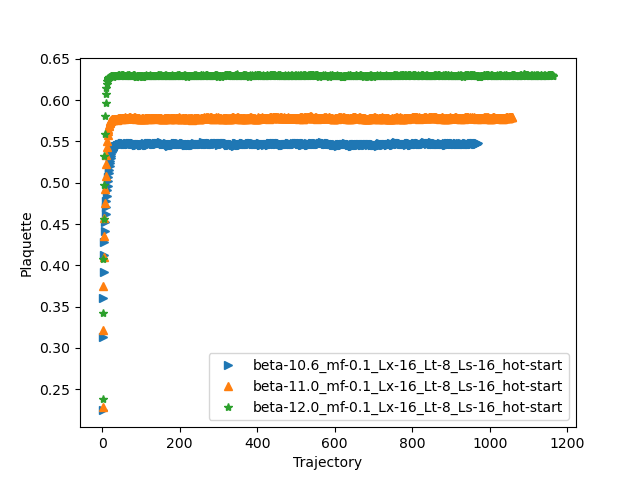

beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


<IPython.core.display.Javascript object>


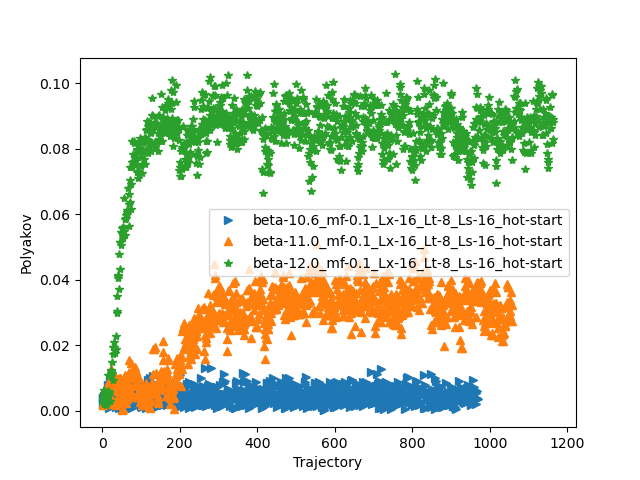

beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


In [25]:

def f_plot_specific_runs(data_dict,column,keys_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    assert len(keys_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):

        df=data_dict[i]
        label=i
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
# beta_list=[9.0,10.0,10.2,10.4,10.5,10.6,10.8]
beta_list=[10.6, 11.0, 12.0 ][:]
mf_list=[0.1]
## Gather dict keys with given beta and mf values
Ls=16
Lt=8
keys_list=['beta-%s_mf-%s_Lx-16_Lt-%s_Ls-%s_hot-start'%(b,m,Lt,Ls) for m in mf_list for b in beta_list]

f_plot_specific_runs(data_dict,'Plaquette',keys_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',keys_list)

f_plot_specific_runs(data_dict,'Polyakov',keys_list)
plt.savefig('Polyakov_details.pdf')


<IPython.core.display.Javascript object>


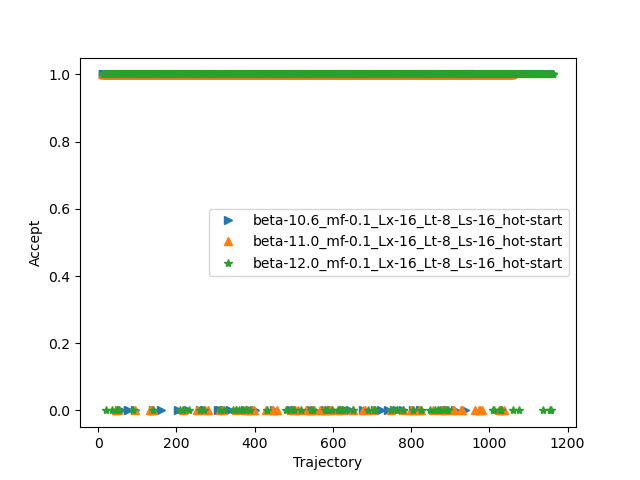

beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


In [26]:
f_plot_specific_runs(data_dict,'Accept',keys_list)


### Plot Polyakov loop

In [27]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


<IPython.core.display.Javascript object>


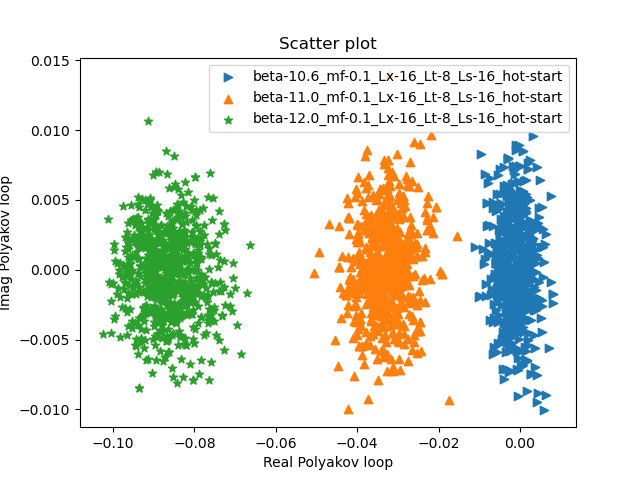

beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-11.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
beta-12.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


In [28]:
keys_list=['beta-%s_mf-%s_Lx-16_Lt-8_Ls-16_hot-start'%(b,m) for m in mf_list for b in beta_list]


equil = 400 
fig=plt.figure()

for i,marker in zip(keys_list,itertools.cycle('>^*sDHPdpx_')):
    df=data_dict[i]
    label=i
    print(label)

    x=df.iter.values[equil:]
    y=df.Polyakov.values[equil:]

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [29]:
df

,Plaquette,iter,Polyakov,Traj_time,Accept
0,0.237987,1.0,0.003921+0.001999j,105.484001,NaN
1,0.342393,2.0,0.001837+0.003020j,130.934006,NaN
2,0.407887,3.0,-0.000207+0.002475j,140.639008,NaN
3,0.456348,4.0,-0.000403-0.001844j,142.266998,NaN
4,0.497191,5.0,0.001049+0.006286j,141.712006,NaN
...,...,...,...,...,...
1159,0.630562,1160.0,-0.096423+0.000113j,74.996696,1.0
1160,0.630096,1161.0,-0.096604+0.002310j,74.464600,1.0
1161,0.629119,1162.0,-0.088112-0.003046j,73.727303,1.0
1162,0.628974,1163.0,-0.088654+0.006979j,74.189796,1.0


<IPython.core.display.Javascript object>


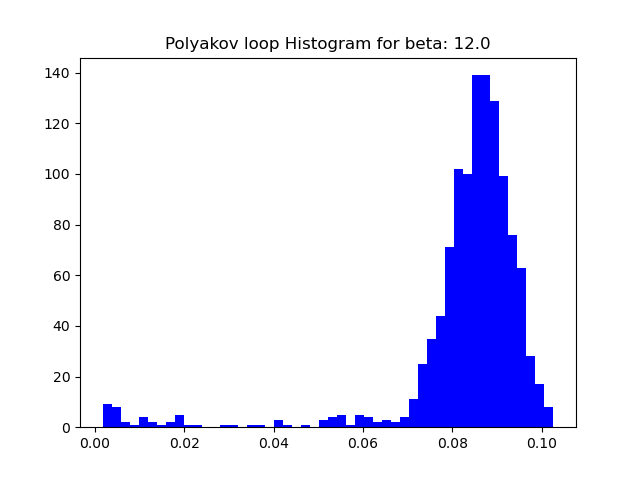

In [30]:
# Histogram
beta=12.0
mf=0.1
key='beta-%s_mf-%s_Lx-16_Lt-8_Ls-16_hot-start'%(beta,mf)

df=data_dict[key]

fig=plt.figure()
x=df.iter.values
y=np.abs(df.Polyakov.values)

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=50,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('fig_output/ploop_histogram_12.0.pdf')